# Data Investigation - Weather Data

### Key Take Aways:

- Summer gets warm and windy
- Winter gets cool and calmer
- Year round it is at least a little cloudy (rank 3 out of 8)
- On the rare occurance of rain, primarily in Winter (Early December through Early April), it is in very little volume

### Import Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from glob import glob

import seaborn as sns
sns.set()

In [2]:
print('Loading Weather Data...')

try:
    file_path_slug = '../../../datasets/bayareabikeshare/*_weather_data.csv'
    file_list = glob(file_path_slug)

    weather_import = pd.DataFrame()

    counter = 1
    chunks = []

    for file in file_list:
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):
            chunk.columns = ['Date', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF', 'Max_Dew_Point_F', 
                             'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
                             'Max_Sea_Level_Pressure_In', 'Mean_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In', 
                             'Max_Visibility_Miles', 'Mean_Visibility_Miles', 'Min_Visibility_Miles', 
                             'Max_Wind_Speed_MPH', 'Mean_Wind_Speed_MPH', 'Max_Gust_Speed_MPH', 'Precipitation_In', 
                             'Cloud_Cover', 'Events', 'Wind_Dir_Degrees', 'zip']
            chunks.append(chunk)
        print('\tfinished file! (%d of %d)'% (counter, len(file_list)))
        counter += 1

    weather_import = pd.concat(chunks)
    print('Data Loaded Successfully!')
except:
    print('oops... something went wrong loading the data :()')

Loading Weather Data...
	finished file! (1 of 4)
	finished file! (2 of 4)
	finished file! (3 of 4)
	finished file! (4 of 4)
Data Loaded Successfully!


In [3]:
weather_import.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5495 entries, 0 to 1824
Data columns (total 24 columns):
Date                          5495 non-null object
Max_Temperature_F             5491 non-null float64
Mean_Temperature_F            5491 non-null float64
Min_TemperatureF              5491 non-null float64
Max_Dew_Point_F               5441 non-null float64
MeanDew_Point_F               5441 non-null float64
Min_Dewpoint_F                5441 non-null float64
Max_Humidity                  5441 non-null float64
Mean_Humidity                 5441 non-null float64
Min_Humidity                  5441 non-null float64
Max_Sea_Level_Pressure_In     5494 non-null float64
Mean_Sea_Level_Pressure_In    5494 non-null float64
Min_Sea_Level_Pressure_In     5494 non-null float64
Max_Visibility_Miles          5473 non-null float64
Mean_Visibility_Miles         5473 non-null float64
Min_Visibility_Miles          5473 non-null float64
Max_Wind_Speed_MPH            5494 non-null float64
Mean_Wind_

### Clean Data

In [4]:
print('Weather Data Cleanup Started...')

weather_data = weather_import.copy()

# cleanup column names
print('\tcleaning column names')
new_cols = []
for col in weather_data.columns:
    new_cols.append(col.replace(' ', '_').lower())
weather_data.columns = new_cols

# convert end and start dates to datetime objects
print('\tconverting dates to datetime objects')
weather_data['date'] = pd.to_datetime(weather_data['date'], format="%m/%d/%Y")

# extract columns we want to keep
print('\tsubsetting to useful columns')
important_cols = ['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperaturef',
                  'max_wind_speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
                  'precipitation_in', 'cloud_cover', 'events', 'zip']
weather_data = weather_data[important_cols]

# rename columns
weather_data.columns = ['date', 'max_temp', 'mean_temp', 'min_temp',
                        'max_wind', 'mean_wind', 'max_gust',
                        'precipitation', 'cloud_cover', 'events', 'zip']

# cleanup and set date as index
weather_data.set_index('date', inplace=True)
weather_data.sort_index(inplace=True)

# cleanup precipitation data to be all float values
weather_data['precipitation'] = pd.to_numeric(weather_data['precipitation'], errors='coerce')
weather_data['precipitation'].fillna(0.0, inplace=True)

print('Weather Data Cleanup complete')
weather_clean = weather_data.copy()

Weather Data Cleanup Started...
	cleaning column names
	converting dates to datetime objects
	subsetting to useful columns
Weather Data Cleanup complete


In [5]:
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5495 entries, 2013-08-29 to 2016-08-31
Data columns (total 10 columns):
max_temp         5491 non-null float64
mean_temp        5491 non-null float64
min_temp         5491 non-null float64
max_wind         5494 non-null float64
mean_wind        5494 non-null float64
max_gust         4060 non-null float64
precipitation    5495 non-null float64
cloud_cover      5494 non-null float64
events           888 non-null object
zip              5495 non-null int64
dtypes: float64(8), int64(1), object(1)
memory usage: 472.2+ KB


In [6]:
# resample Mean
weather_monthly_mean = weather_clean.resample('M').mean()
weather_monthly_rolling_mean = weather_clean.resample('M').mean().fillna(0).rolling(window=3, min_periods=1).mean()

# resample Min
weather_monthly_min = weather_clean.resample('M').min()
weather_monthly_rolling_min = weather_clean.resample('M').min().fillna(0).rolling(window=3, min_periods=1).min()

# resample Max
weather_monthly_max = weather_clean.resample('M').max()
weather_monthly_rolling_max = weather_clean.resample('M').max().fillna(0).rolling(window=3, min_periods=1).max()

# resample Median
weather_monthly_median = weather_clean.resample('M').median()
weather_monthly_rolling_median = weather_clean.resample('M').median().fillna(0).rolling(window=3, min_periods=1).median()

## Graphical EDA of Weather Data

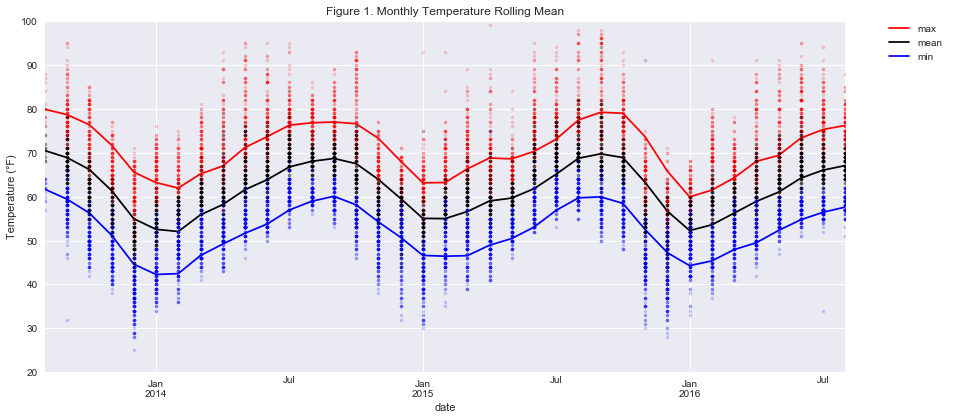

In [7]:
# plot Temperature Max
ax = weather_monthly_rolling_mean['max_temp'].plot(figsize=(12,6), label='max_rolling', color='r')
weather_monthly_rolling_mean['mean_temp'].plot(ax=ax, label='mean_rolling', color='k')
weather_monthly_rolling_mean['min_temp'].plot(ax=ax, label='min_rolling', color='b')
weather_clean['max_temp'].plot(ax=ax, label='mean', linestyle='None', marker='.', color='r', alpha=0.2)
weather_clean['mean_temp'].plot(ax=ax, label='mean', linestyle='None', marker='.', color='k', alpha=0.2)
weather_clean['min_temp'].plot(ax=ax, label='mean', linestyle='None', marker='.', color='b', alpha=0.2)

ax.set_ylim(20, 100)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(['max', 'mean', 'min'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Figure 1. Monthly Temperature Rolling Mean')
ax.set_ylabel('Temperature (°F)')
plt.tight_layout()
plt.show()

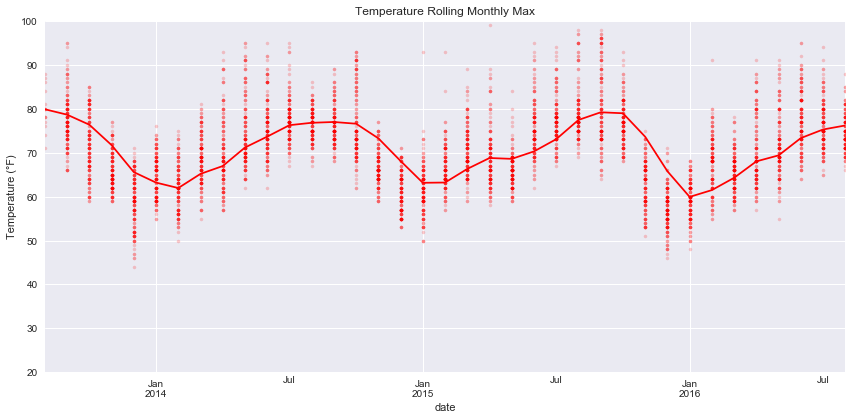

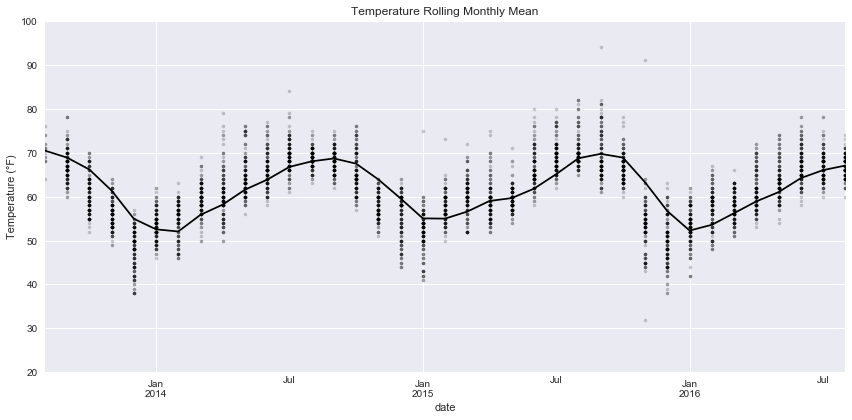

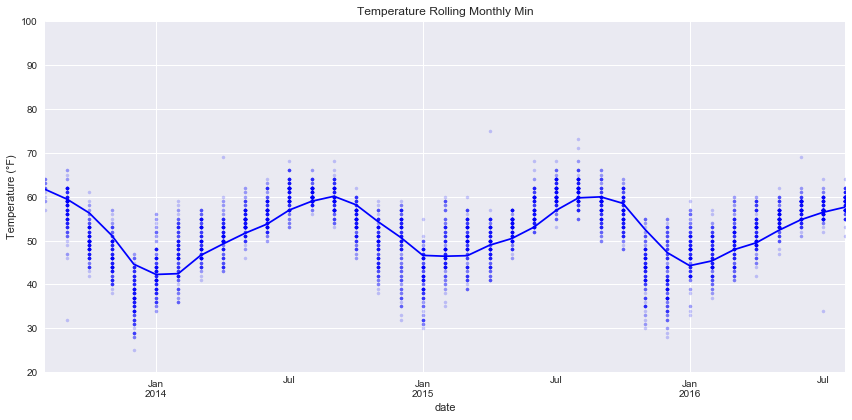

In [8]:
# plot Temperature Max
ax = weather_monthly_rolling_mean['max_temp'].plot(figsize=(12,6), label='max_rolling', color='r')
weather_clean['max_temp'].plot(ax=ax, label='mean', linestyle='None', marker='.', color='r', alpha=0.2)

# plt.legend(['max'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('Temperature (°F)')
ax.set_ylim(20, 100)
plt.title('Temperature Rolling Monthly Max')
plt.tight_layout()
plt.show()


# plot Temperature Mean
ax = weather_monthly_rolling_mean['mean_temp'].plot(figsize=(12,6), label='mean_rolling', color='k')
weather_clean['mean_temp'].plot(ax=ax, label='mean', linestyle='None', marker='.', color='k', alpha=0.2)

# plt.legend(['mean'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('Temperature (°F)')
ax.set_ylim(20, 100)
plt.title('Temperature Rolling Monthly Mean')
plt.tight_layout()
plt.show()


# plot Temperature Min
ax = weather_monthly_rolling_mean['min_temp'].plot(figsize=(12,6), label='min_rolling', color='b')
weather_clean['min_temp'].plot(ax=ax, label='mean', linestyle='None', marker='.', color='b', alpha=0.2)

# plt.legend(['min'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('Temperature (°F)')
ax.set_ylim(20, 100)
plt.title('Temperature Rolling Monthly Min')
plt.tight_layout()
plt.show()

## Graphical EDA of monthly trends

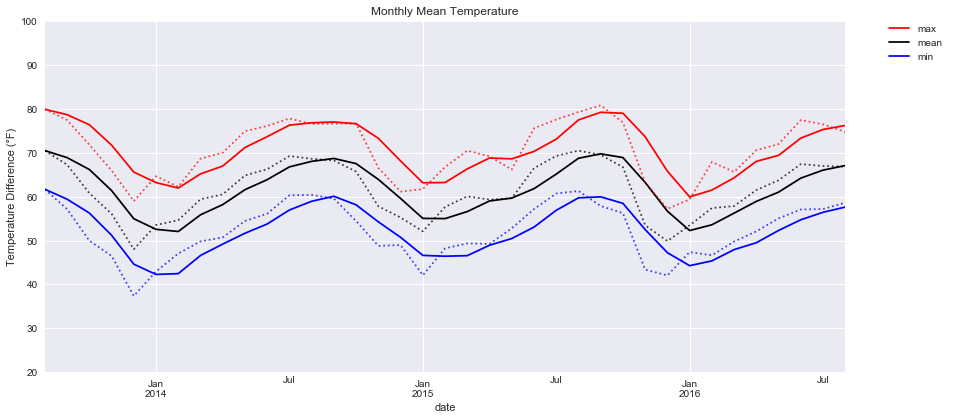

In [9]:
ax = weather_monthly_rolling_mean['max_temp'].plot(figsize=(12,6), label='max_rolling', color='r')
weather_monthly_rolling_mean['mean_temp'].plot(ax=ax, label='mean_rolling', color='k')
weather_monthly_rolling_mean['min_temp'].plot(ax=ax, label='min_rolling', color='b')



weather_monthly_mean['max_temp'].plot(ax=ax, label='max_temp', color='r', linestyle=':', alpha=0.75)
weather_monthly_mean['mean_temp'].plot(ax=ax, label='mean_temp', color='k', linestyle=':', alpha=0.75)
weather_monthly_mean['min_temp'].plot(ax=ax, label='min_temp', color='b', linestyle=':', alpha=0.75)



plt.legend(['max', 'mean', 'min'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('Temperature Difference (°F)')
ax.set_ylim(20, 100)
plt.title('Monthly Mean Temperature')
plt.tight_layout()
plt.show()

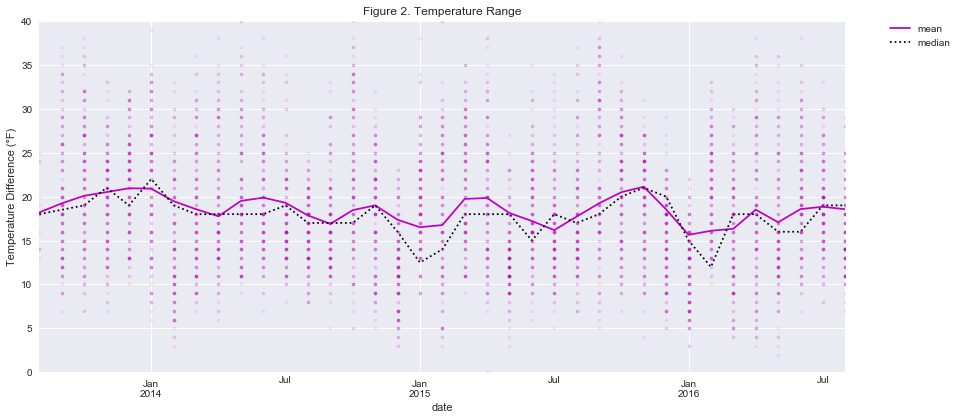

In [10]:
# mean temperature range over time
temp_range = weather_clean['max_temp'] - weather_clean['min_temp']
tr = temp_range.to_frame()
tr.columns = ['range']

rolling_temp_range = weather_monthly_rolling_mean['max_temp'] - weather_monthly_rolling_mean['min_temp']
rtr = rolling_temp_range.to_frame()
rtr.columns = ['range']

rolling_temp_median_range = weather_monthly_rolling_median['max_temp'] - weather_monthly_rolling_median['min_temp']
rtr_median = rolling_temp_median_range.to_frame()
rtr_median.columns = ['range']

ax = rtr['range'].plot(figsize=(12,6), label='mean_range', color='m')
rtr_median['range'].plot(ax=ax, label='median_range', color='k', linestyle=':')
tr['range'].plot(ax=ax, label='range', linestyle='None', marker='.', color='m', alpha=0.1)

plt.legend(['mean', 'median'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('Temperature Difference (°F)')
ax.set_ylim(0, 40)
plt.title('Figure 2. Temperature Range')
plt.tight_layout()
plt.show()

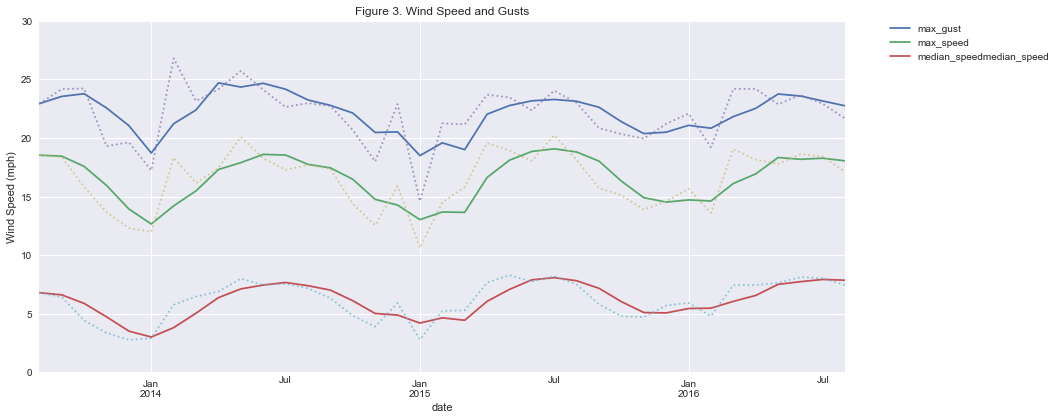

In [11]:
ax = weather_monthly_rolling_mean['max_gust'].plot(figsize=(12,6), label='gust_rolling')
weather_monthly_rolling_mean['max_wind'].plot(ax=ax, label='max_rolling')
weather_monthly_rolling_mean['mean_wind'].plot(ax=ax, label='mean_rolling')

weather_monthly_mean['max_gust'].plot(ax=ax, label='max_gust', linestyle=':', alpha=0.75)
weather_monthly_mean['max_wind'].plot(ax=ax, label='max_wind', linestyle=':', alpha=0.75)
weather_monthly_mean['mean_wind'].plot(ax=ax, label='mean_wind', linestyle=':', alpha=0.75)


ax.set_ylim(0, 30)
plt.legend(['max_gust', 'max_speed', 'median_speedmedian_speed'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('Wind Speed (mph)')
plt.title('Figure 3. Wind Speed and Gusts')
plt.tight_layout()
plt.show()

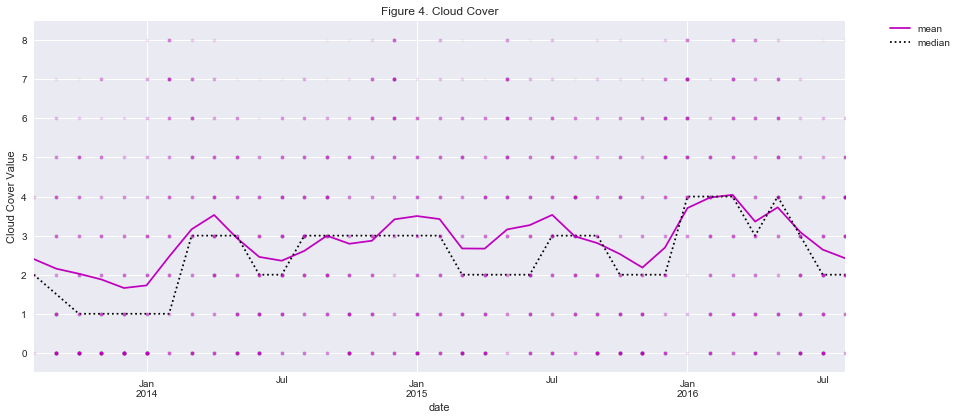

In [12]:
ax = weather_monthly_rolling_mean['cloud_cover'].plot(figsize=(12,6), label='mean', color='m')
weather_monthly_rolling_median['cloud_cover'].plot(ax=ax, label='median', color='k', linestyle=':')
weather_clean['cloud_cover'].plot(ax=ax, label='cloud_cover', linestyle='None', marker='.', color='m', alpha=0.05)

ax.set_ylim(-0.5, 8.5)
plt.legend(['mean', 'median'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Figure 4. Cloud Cover')
ax.set_ylabel('Cloud Cover Value')
plt.tight_layout()
plt.show()

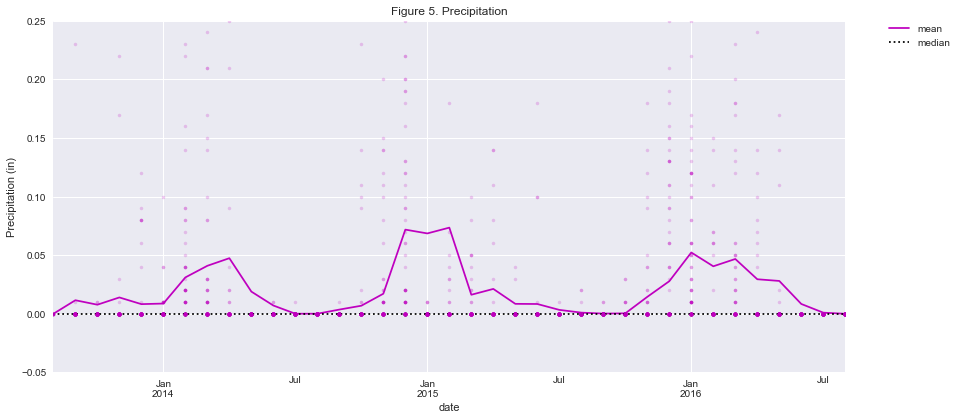

In [13]:
ax = weather_monthly_rolling_mean['precipitation'].plot(figsize=(12,6), label='mean', color='m')
weather_monthly_rolling_median['precipitation'].plot(ax=ax, label='median', color='k', linestyle=':')
weather_clean['precipitation'].plot(ax=ax, label='data', linestyle='None', marker='.', color='m', alpha=0.2)


ax.set_ylim(-0.05, 0.25)
plt.legend(['mean', 'median'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('Precipitation (in)')
plt.title('Figure 5. Precipitation')
plt.tight_layout()
plt.show()